# Feature Engineering - Pipeline MLOps

Este notebook implementa la **Ingeniería de Características** para el proyecto de predicción de Alzheimer.

**🔍 Propósito de este Notebook:**
- Este notebook es **AUTOCONTENIDO** y puede ejecutarse de forma independiente
- Muestra de forma manual y gráfica el proceso de Feature Engineering
- No depende de scripts externos ni de pasos anteriores
- Ideal para revisión, comprensión y experimentación

**Funcionalidades:**
- Carga de datos directamente desde el CSV original
- Limpieza básica de datos (eliminar IDs, duplicados)
- Creación de features derivados basados en el análisis EDA
- Clasificación automática de tipos de variables
- Construcción de pipelines de preprocesamiento (sklearn)
- Transformaciones: imputación, escalado, codificación
- Separación train-test estratificada
- Visualizaciones del proceso de transformación
- Guardado de artefactos (preprocessor, datasets transformados)

**📋 Diferencia con los Scripts:**
- **Notebooks (`/notebooks/`)**: Revisión manual paso a paso, con visualizaciones y explicaciones
- **Scripts (`/scripts/`)**: Automatización para ejecución completa del pipeline y Docker

**Basado en hallazgos del EDA:** `comprension_eda.ipynb` (Sección 8.7)

In [16]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import json
import os
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn para feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerías importadas correctamente")
print(f"✓ Pandas versión: {pd.__version__}")
print(f"✓ Numpy versión: {np.__version__}")

✓ Librerías importadas correctamente
✓ Pandas versión: 1.5.3
✓ Numpy versión: 1.24.3


## 1. Cargar Datos Originales y Configuración

Cargamos el dataset original directamente desde el CSV y la configuración del proyecto.

**Nota:** Este notebook NO depende de pasos anteriores. Carga los datos originales y realiza toda la limpieza necesaria.

In [20]:
# Cargar configuración
config_path = "../../../config.json"

if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
    print("✓ Configuración cargada desde config.json")
else:
    config = {"training": {"test_size": 0.2, "random_state": 42}}
    print("⚠️ config.json no encontrado. Usando configuración por defecto")

# Extraer parámetros de entrenamiento
test_size = config.get('training', {}).get('test_size', 0.2)
random_state = config.get('training', {}).get('random_state', 42)

print(f"\n📊 Parámetros de configuración:")
print(f"   • Test size: {test_size}")
print(f"   • Random state: {random_state}")

✓ Configuración cargada desde config.json

📊 Parámetros de configuración:
   • Test size: 0.2
   • Random state: 42


In [23]:
# Cargar dataset ORIGINAL (no procesado)
# Buscar primero desde config.json, sino usar el path por defecto

data_path = None

# Intentar cargar desde config
if os.path.exists(config_path):
    data_path = config.get('data_path_notebooks', "../../../alzheimers_disease_data.csv")
else:
    data_path = "../../../alzheimers_disease_data.csv"

# Cargar dataset original
if not os.path.exists(data_path):
    print("❌ ERROR: No se encontró el archivo de datos")
    print(f"   Buscado en: {data_path}")
    print("   Por favor, verifica que el archivo CSV existe en la ruta correcta")
else:
    df_raw = pd.read_csv(data_path)
    print(f"✓ Dataset ORIGINAL cargado desde: {data_path}")
    print(f"  Dimensiones: {df_raw.shape[0]} filas × {df_raw.shape[1]} columnas")
    print(f"\n📋 Primeras filas del dataset ORIGINAL:")
    display(df_raw.head())

✓ Dataset ORIGINAL cargado desde: ../../../alzheimers_disease_data.csv
  Dimensiones: 2149 filas × 35 columnas

📋 Primeras filas del dataset ORIGINAL:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


## 1.5 Limpieza Básica de Datos

Realizamos limpieza básica antes del feature engineering:
- Eliminar columnas de identificación (PatientID, DoctorInCharge)
- Eliminar duplicados
- Verificar tipos de datos

In [24]:
print("="*80)
print("LIMPIEZA BÁSICA DE DATOS")
print("="*80 + "\n")

# Crear copia para no modificar el original
df = df_raw.copy()

print(f"📊 Dataset original: {df.shape[0]} filas × {df.shape[1]} columnas")

# 1. Eliminar duplicados
n_duplicates = df.duplicated().sum()
if n_duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Eliminados {n_duplicates} registros duplicados")
else:
    print("✓ No se encontraron duplicados")

# 2. Eliminar columnas de identificación (no son features predictivos)
id_columns = ['PatientID', 'DoctorInCharge']
existing_id_cols = [col for col in id_columns if col in df.columns]

if existing_id_cols:
    df = df.drop(columns=existing_id_cols)
    print(f"✓ Eliminadas columnas de identificación: {existing_id_cols}")

# 3. Información sobre valores faltantes (se manejarán en el pipeline)
missing_info = df.isnull().sum()
if missing_info.sum() > 0:
    print(f"\n📊 Valores faltantes detectados (se imputarán en el pipeline):")
    for col, count in missing_info[missing_info > 0].items():
        pct = (count / len(df)) * 100
        print(f"   {col}: {count} ({pct:.2f}%)")
else:
    print("\n✓ No hay valores faltantes")

# 4. Verificar tipos de datos
print(f"\n📋 Tipos de datos:")
numeric_cols_check = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_check = df.select_dtypes(include=['object']).columns.tolist()
print(f"   Numéricas: {len(numeric_cols_check)} columnas")
print(f"   Categóricas: {len(categorical_cols_check)} columnas")

print(f"\n✅ Limpieza completada")
print(f"   Dimensiones finales: {df.shape[0]} filas × {df.shape[1]} columnas")

print("\n" + "="*80)

LIMPIEZA BÁSICA DE DATOS

📊 Dataset original: 2149 filas × 35 columnas
✓ No se encontraron duplicados
✓ Eliminadas columnas de identificación: ['PatientID', 'DoctorInCharge']

✓ No hay valores faltantes

📋 Tipos de datos:
   Numéricas: 33 columnas
   Categóricas: 0 columnas

✅ Limpieza completada
   Dimensiones finales: 2149 filas × 33 columnas



## 2. Creación de Features Derivados

Basado en el análisis EDA (`comprension_eda.ipynb` Sección 8.7), implementamos los features derivados más relevantes.

In [25]:
def create_derived_features(df):
    """
    Crea features derivados basados en el análisis EDA.
    
    Features implementados:
    1. Cholesterol_Ratio (LDL/HDL) - Indicador de riesgo cardiovascular
    2. Cholesterol_Total_HDL_Ratio - Otro indicador cardiovascular
    3. Mean_Arterial_Pressure (MAP) - Perfusión cerebral
    4. Age_Squared - Capturar relación no lineal con edad
    5. Age_FH_Interaction - Interacción edad x historia familiar
    
    Args:
        df: DataFrame original
        
    Returns:
        DataFrame con features derivados agregados
    """
    df_new = df.copy()
    features_created = []
    
    print("="*80)
    print("CREANDO FEATURES DERIVADOS")
    print("="*80 + "\n")
    
    # 1. Ratio de Colesterol LDL/HDL
    if 'CholesterolLDL' in df.columns and 'CholesterolHDL' in df.columns:
        df_new['Cholesterol_Ratio_LDL_HDL'] = df_new['CholesterolLDL'] / df_new['CholesterolHDL']
        features_created.append('Cholesterol_Ratio_LDL_HDL')
        print("✓ Creado: Cholesterol_Ratio_LDL_HDL (LDL/HDL)")
    
    # 2. Ratio de Colesterol Total/HDL
    if 'CholesterolTotal' in df.columns and 'CholesterolHDL' in df.columns:
        df_new['Cholesterol_Total_HDL_Ratio'] = df_new['CholesterolTotal'] / df_new['CholesterolHDL']
        features_created.append('Cholesterol_Total_HDL_Ratio')
        print("✓ Creado: Cholesterol_Total_HDL_Ratio (Total/HDL)")
    
    # 3. Presión Arterial Media (MAP)
    if 'SystolicBP' in df.columns and 'DiastolicBP' in df.columns:
        df_new['Mean_Arterial_Pressure'] = (
            df_new['DiastolicBP'] + (df_new['SystolicBP'] - df_new['DiastolicBP']) / 3
        )
        features_created.append('Mean_Arterial_Pressure')
        print("✓ Creado: Mean_Arterial_Pressure (MAP)")
    
    # 4. Edad al cuadrado
    if 'Age' in df.columns:
        df_new['Age_Squared'] = df_new['Age'] ** 2
        features_created.append('Age_Squared')
        print("✓ Creado: Age_Squared (Age²)")
    
    # 5. Interacción Edad x Historia Familiar
    if 'Age' in df.columns and 'FamilyHistoryAlzheimers' in df.columns:
        df_new['Age_FH_Interaction'] = df_new['Age'] * df_new['FamilyHistoryAlzheimers']
        features_created.append('Age_FH_Interaction')
        print("✓ Creado: Age_FH_Interaction (Age × FamilyHistory)")
    
    # 6. Score de riesgo cardiovascular (suma de condiciones)
    cv_conditions = ['CardiovascularDisease', 'Diabetes', 'Hypertension']
    if all(col in df.columns for col in cv_conditions):
        df_new['CV_Risk_Score'] = df_new[cv_conditions].sum(axis=1)
        features_created.append('CV_Risk_Score')
        print("✓ Creado: CV_Risk_Score (suma de condiciones cardiovasculares)")
    
    # Manejar valores infinitos o NaN resultantes
    for col in features_created:
        # Reemplazar infinitos con NaN
        df_new[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Contar NaNs
        n_nan = df_new[col].isna().sum()
        if n_nan > 0:
            print(f"   ⚠️ {col}: {n_nan} valores NaN (serán imputados en el pipeline)")
    
    print(f"\n✅ Total de features derivados creados: {len(features_created)}")
    print(f"   Dimensiones nuevas: {df_new.shape[0]} filas × {df_new.shape[1]} columnas")
    print(f"   Features agregados: {len(features_created)}")
    
    return df_new

# Aplicar transformación
df_with_features = create_derived_features(df)

print("\n" + "="*80)

CREANDO FEATURES DERIVADOS

✓ Creado: Cholesterol_Ratio_LDL_HDL (LDL/HDL)
✓ Creado: Cholesterol_Total_HDL_Ratio (Total/HDL)
✓ Creado: Mean_Arterial_Pressure (MAP)
✓ Creado: Age_Squared (Age²)
✓ Creado: Age_FH_Interaction (Age × FamilyHistory)
✓ Creado: CV_Risk_Score (suma de condiciones cardiovasculares)

✅ Total de features derivados creados: 6
   Dimensiones nuevas: 2149 filas × 39 columnas
   Features agregados: 6



## 3. Clasificación de Tipos de Variables

Identificamos y clasificamos las variables en numéricas, categóricas nominales y categóricas ordinales.

In [26]:
# Definir variable objetivo
target_col = 'Diagnosis'

print("="*80)
print("CLASIFICACIÓN DE CARACTERÍSTICAS")
print("="*80 + "\n")

# Separar features del target
if target_col in df_with_features.columns:
    feature_cols = [col for col in df_with_features.columns if col != target_col]
    df_features = df_with_features[feature_cols]
    print(f"✓ Variable objetivo identificada: {target_col}")
    print(f"✓ Total de features: {len(feature_cols)}")
else:
    print(f"⚠️ Variable objetivo '{target_col}' no encontrada")
    df_features = df_with_features
    feature_cols = df_features.columns.tolist()

# Detectar tipos automáticamente
numeric_features = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_features.select_dtypes(include=['object']).columns.tolist()

# Para este dataset, todas las categóricas son nominales
# Si hubiera ordinales específicas (ej: 'EducationLevel'), se definirían aquí
ordinal_features = []
nominal_features = categorical_features

print(f"\n📊 Variables Numéricas ({len(numeric_features)}):")
if numeric_features:
    for i, col in enumerate(numeric_features[:10], 1):
        print(f"   {i}. {col}")
    if len(numeric_features) > 10:
        print(f"   ... y {len(numeric_features) - 10} más")

print(f"\n📝 Variables Categóricas Nominales ({len(nominal_features)}):")
if nominal_features:
    for i, col in enumerate(nominal_features, 1):
        print(f"   {i}. {col}")
else:
    print("   Ninguna")

print(f"\n📈 Variables Categóricas Ordinales ({len(ordinal_features)}):")
if ordinal_features:
    for i, col in enumerate(ordinal_features, 1):
        print(f"   {i}. {col}")
else:
    print("   Ninguna")

print("\n" + "="*80)

CLASIFICACIÓN DE CARACTERÍSTICAS

✓ Variable objetivo identificada: Diagnosis
✓ Total de features: 38

📊 Variables Numéricas (38):
   1. Age
   2. Gender
   3. Ethnicity
   4. EducationLevel
   5. BMI
   6. Smoking
   7. AlcoholConsumption
   8. PhysicalActivity
   9. DietQuality
   10. SleepQuality
   ... y 28 más

📝 Variables Categóricas Nominales (0):
   Ninguna

📈 Variables Categóricas Ordinales (0):
   Ninguna



## 4. Construcción de Pipelines de Preprocesamiento

Creamos pipelines específicos para cada tipo de variable usando sklearn `Pipeline` y `ColumnTransformer`.

In [27]:
print("="*80)
print("CONSTRUCCIÓN DE PIPELINES DE PREPROCESAMIENTO")
print("="*80 + "\n")

transformers_list = []

# Pipeline para variables numéricas
if numeric_features:
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    transformers_list.append(('numeric', numeric_pipeline, numeric_features))
    
    print(f"✓ Pipeline Numérico ({len(numeric_features)} features):")
    print(f"    1. SimpleImputer(strategy='median') - Imputa valores faltantes con la mediana")
    print(f"    2. StandardScaler() - Normaliza con media=0 y std=1")
    print()

# Pipeline para variables categóricas nominales
if nominal_features:
    nominal_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    transformers_list.append(('nominal', nominal_pipeline, nominal_features))
    
    print(f"✓ Pipeline Categórico Nominal ({len(nominal_features)} features):")
    print(f"    1. SimpleImputer(strategy='most_frequent') - Imputa con el valor más frecuente")
    print(f"    2. OneHotEncoder(handle_unknown='ignore') - Codificación one-hot")
    print()

# Pipeline para variables categóricas ordinales
if ordinal_features:
    ordinal_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    transformers_list.append(('ordinal', ordinal_pipeline, ordinal_features))
    
    print(f"✓ Pipeline Categórico Ordinal ({len(ordinal_features)} features):")
    print(f"    1. SimpleImputer(strategy='most_frequent')")
    print(f"    2. OrdinalEncoder(handle_unknown='use_encoded_value')")
    print()

# Crear ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='drop'  # Eliminar columnas no especificadas
)

print(f"✅ ColumnTransformer creado con {len(transformers_list)} transformadores")
print(f"   • Transformadores: {[t[0] for t in transformers_list]}")
print(f"   • Remainder: 'drop' (columnas no especificadas serán eliminadas)")

print("\n" + "="*80)

CONSTRUCCIÓN DE PIPELINES DE PREPROCESAMIENTO

✓ Pipeline Numérico (38 features):
    1. SimpleImputer(strategy='median') - Imputa valores faltantes con la mediana
    2. StandardScaler() - Normaliza con media=0 y std=1

✅ ColumnTransformer creado con 1 transformadores
   • Transformadores: ['numeric']
   • Remainder: 'drop' (columnas no especificadas serán eliminadas)



## 5. Separación Train-Test

Separamos los datos en conjuntos de entrenamiento y evaluación con estratificación.

In [28]:
print("="*80)
print("SEPARACIÓN DE DATOS TRAIN-TEST")
print("="*80 + "\n")

# Separar features (X) y target (y)
X = df_with_features.drop(columns=[target_col])
y = df_with_features[target_col]

print(f"✓ Features (X): {X.shape}")
print(f"✓ Target (y): {y.shape}")

# Train-test split con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y  # Mantener proporción de clases
)

print(f"\n📊 División train-test ({int((1-test_size)*100)}-{int(test_size*100)}):")
print(f"   Entrenamiento: {X_train.shape[0]:,} muestras ({(X_train.shape[0]/len(y)*100):.1f}%)")
print(f"   Evaluación:    {X_test.shape[0]:,} muestras ({(X_test.shape[0]/len(y)*100):.1f}%)")

# Verificar distribución de clases
print(f"\n📈 Distribución del target en ENTRENAMIENTO:")
train_dist = y_train.value_counts().sort_index()
for label, count in train_dist.items():
    print(f"   Clase {label}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\n📈 Distribución del target en EVALUACIÓN:")
test_dist = y_test.value_counts().sort_index()
for label, count in test_dist.items():
    print(f"   Clase {label}: {count:,} ({count/len(y_test)*100:.1f}%)")

# Verificar que la estratificación funcionó correctamente
print("\n✓ Estratificación exitosa: proporciones similares entre train y test")

print("\n" + "="*80)

SEPARACIÓN DE DATOS TRAIN-TEST

✓ Features (X): (2149, 38)
✓ Target (y): (2149,)

📊 División train-test (80-20):
   Entrenamiento: 1,719 muestras (80.0%)
   Evaluación:    430 muestras (20.0%)

📈 Distribución del target en ENTRENAMIENTO:
   Clase 0: 1,111 (64.6%)
   Clase 1: 608 (35.4%)

📈 Distribución del target en EVALUACIÓN:
   Clase 0: 278 (64.7%)
   Clase 1: 152 (35.3%)

✓ Estratificación exitosa: proporciones similares entre train y test



## 6. Ajuste y Transformación de Datos

Ajustamos el preprocessor SOLO con datos de entrenamiento (evitar data leakage) y transformamos ambos conjuntos.

In [29]:
print("="*80)
print("AJUSTE Y TRANSFORMACIÓN")
print("="*80 + "\n")

print("📊 Ajustando preprocessor con datos de entrenamiento...")
print("   (IMPORTANTE: Solo usar train para evitar data leakage)")
preprocessor.fit(X_train)
print("✓ Preprocessor ajustado exitosamente")

print("\n🔄 Transformando datos de entrenamiento...")
X_train_transformed = preprocessor.transform(X_train)
print(f"✓ X_train transformado: {X_train_transformed.shape}")

print("\n🔄 Transformando datos de evaluación...")
X_test_transformed = preprocessor.transform(X_test)
print(f"✓ X_test transformado: {X_test_transformed.shape}")

print(f"\n📈 Resumen de transformación:")
print(f"   Features originales:    {X_train.shape[1]}")
print(f"   Features transformados: {X_train_transformed.shape[1]}")
print(f"   Diferencia: {X_train_transformed.shape[1] - X_train.shape[1]:+d}")

# Explicar el aumento en features (si aplica)
if X_train_transformed.shape[1] > X_train.shape[1]:
    print(f"\n💡 Nota: El aumento de features se debe a:")
    print(f"   • OneHotEncoder crea una columna por cada categoría")
    print(f"   • Variables categóricas: {len(nominal_features)}")
    
print("\n" + "="*80)

AJUSTE Y TRANSFORMACIÓN

📊 Ajustando preprocessor con datos de entrenamiento...
   (IMPORTANTE: Solo usar train para evitar data leakage)
✓ Preprocessor ajustado exitosamente

🔄 Transformando datos de entrenamiento...
✓ X_train transformado: (1719, 38)

🔄 Transformando datos de evaluación...
✓ X_test transformado: (430, 38)

📈 Resumen de transformación:
   Features originales:    38
   Features transformados: 38
   Diferencia: +0



## 7. Visualización Post-Transformación

Verifiquemos visualmente cómo se ven los datos transformados.

📊 Primeras 6 features transformadas (X_train):



,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5
0,1.230721,-1.009939,1.298741,-0.317924,0.065466,-0.642254
1,-1.430841,0.990159,-0.703533,1.903666,0.070065,1.557017
2,0.010838,-1.009939,-0.703533,-1.428719,-0.316941,-0.642254
3,1.563416,-1.009939,-0.703533,-1.428719,-0.567289,-0.642254
4,0.121737,0.990159,-0.703533,0.792871,1.533521,1.557017



📈 Estadísticas de features transformadas:
   Min:  -2.3487
   Max:  4.2676
   Mean: 0.0000
   Std:  1.0000

✓ No hay valores NaN
✓ No hay valores infinitos

📊 Distribución de primeras 4 features numéricas escaladas:


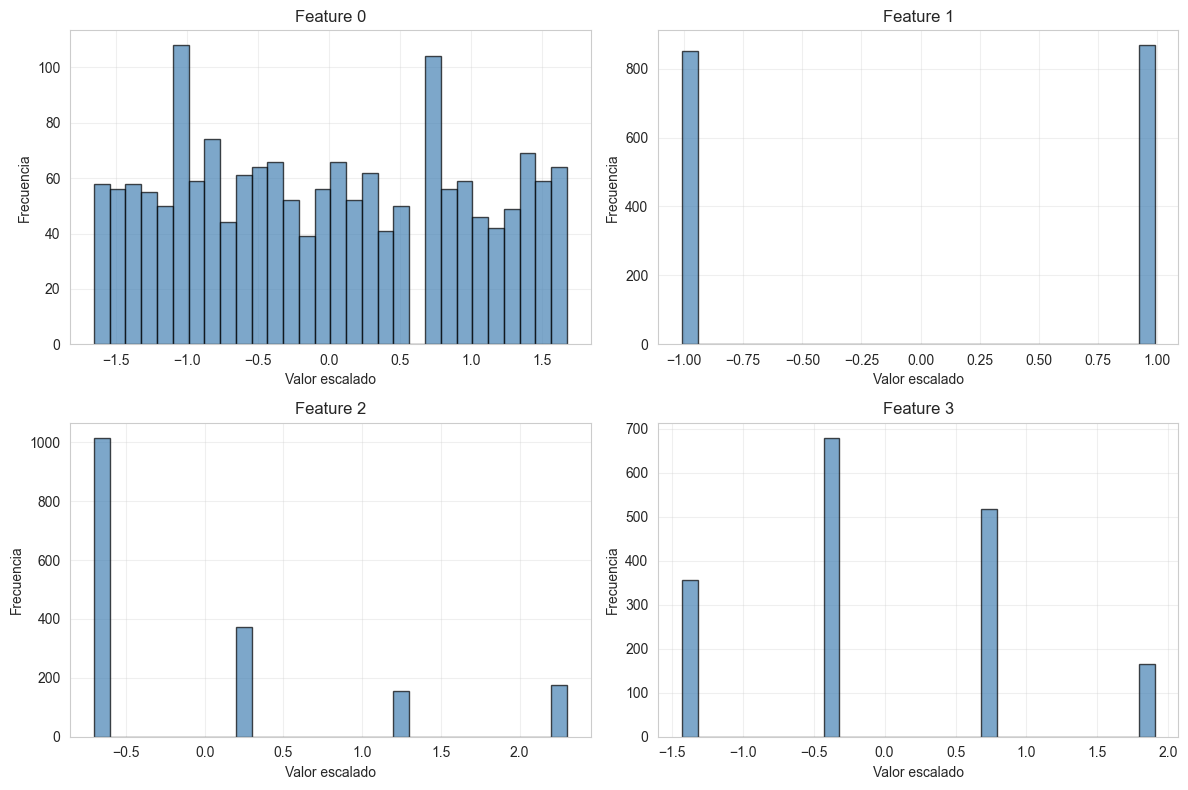


💡 Interpretación:
   • Features numéricas deberían estar centradas en 0 con std ≈ 1 (StandardScaler)
   • Features one-hot deberían tener valores 0 o 1
   • Distribuciones pueden ser no-normales, pero sin valores extremos


In [30]:
# Visualizar primeras 6 features transformadas
print("📊 Primeras 6 features transformadas (X_train):\n")

# Convertir a DataFrame para visualización
X_train_df = pd.DataFrame(
    X_train_transformed[:5], 
    columns=[f'Feature_{i}' for i in range(X_train_transformed.shape[1])]
)
display(X_train_df.iloc[:, :6])  # Mostrar primeras 6 columnas

# Estadísticas de las features transformadas
print("\n📈 Estadísticas de features transformadas:")
print(f"   Min:  {X_train_transformed.min():.4f}")
print(f"   Max:  {X_train_transformed.max():.4f}")
print(f"   Mean: {X_train_transformed.mean():.4f}")
print(f"   Std:  {X_train_transformed.std():.4f}")

# Verificar valores NaN o infinitos
n_nan = np.isnan(X_train_transformed).sum()
n_inf = np.isinf(X_train_transformed).sum()

if n_nan > 0:
    print(f"\n⚠️ Advertencia: {n_nan} valores NaN encontrados")
else:
    print(f"\n✓ No hay valores NaN")

if n_inf > 0:
    print(f"⚠️ Advertencia: {n_inf} valores infinitos encontrados")
else:
    print(f"✓ No hay valores infinitos")

# Visualizar distribución de algunas features
print("\n📊 Distribución de primeras 4 features numéricas escaladas:")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(min(4, X_train_transformed.shape[1])):
    ax = axes[i]
    ax.hist(X_train_transformed[:, i], bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Valor escalado')
    ax.set_ylabel('Frecuencia')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("   • Features numéricas deberían estar centradas en 0 con std ≈ 1 (StandardScaler)")
print("   • Features one-hot deberían tener valores 0 o 1")
print("   • Distribuciones pueden ser no-normales, pero sin valores extremos")

## 8. Guardado de Artefactos

Guardamos el preprocessor ajustado y los datasets transformados para uso en el siguiente paso del pipeline.

In [31]:
print("="*80)
print("GUARDANDO ARTEFACTOS")
print("="*80 + "\n")

# Crear directorios si no existen
artifacts_dir = Path("../../artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path("../../data/processed")
data_dir.mkdir(parents=True, exist_ok=True)

# 1. Guardar preprocessor ajustado
preprocessor_path = artifacts_dir / "preprocessor.joblib"
joblib.dump(preprocessor, preprocessor_path)
print(f"💾 Preprocessor guardado en: {preprocessor_path}")
print(f"   Tamaño: {preprocessor_path.stat().st_size / 1024:.2f} KB")

# 2. Guardar datasets transformados como CSV
X_train_df = pd.DataFrame(X_train_transformed)
X_test_df = pd.DataFrame(X_test_transformed)
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

X_train_path = data_dir / "X_train.csv"
X_test_path = data_dir / "X_test.csv"
y_train_path = data_dir / "y_train.csv"
y_test_path = data_dir / "y_test.csv"

X_train_df.to_csv(X_train_path, index=False)
X_test_df.to_csv(X_test_path, index=False)
y_train_df.to_csv(y_train_path, index=False)
y_test_df.to_csv(y_test_path, index=False)

print(f"\n💾 Datasets guardados en: {data_dir}")
print(f"   • X_train.csv: {X_train_path.stat().st_size / 1024:.2f} KB")
print(f"   • X_test.csv:  {X_test_path.stat().st_size / 1024:.2f} KB")
print(f"   • y_train.csv: {y_train_path.stat().st_size / 1024:.2f} KB")
print(f"   • y_test.csv:  {y_test_path.stat().st_size / 1024:.2f} KB")

# 3. Guardar metadatos
metadata = {
    "n_features_original": X_train.shape[1],
    "n_features_transformed": X_train_transformed.shape[1],
    "n_numeric_features": len(numeric_features),
    "n_categorical_features": len(nominal_features),
    "n_samples_train": X_train.shape[0],
    "n_samples_test": X_test.shape[0],
    "test_size": test_size,
    "random_state": random_state,
    "target_column": target_col,
    "features_created": [
        'Cholesterol_Ratio_LDL_HDL',
        'Cholesterol_Total_HDL_Ratio',
        'Mean_Arterial_Pressure',
        'Age_Squared',
        'Age_FH_Interaction',
        'CV_Risk_Score'
    ]
}

metadata_path = artifacts_dir / "feature_engineering_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n💾 Metadata guardado en: {metadata_path}")

print("\n" + "="*80)
print("✅ ARTEFACTOS GUARDADOS EXITOSAMENTE")
print("="*80)

GUARDANDO ARTEFACTOS

💾 Preprocessor guardado en: ..\..\artifacts\preprocessor.joblib
   Tamaño: 5.47 KB

💾 Datasets guardados en: ..\..\data\processed
   • X_train.csv: 1257.41 KB
   • X_test.csv:  314.63 KB
   • y_train.csv: 5.05 KB
   • y_test.csv:  1.27 KB

💾 Metadata guardado en: ..\..\artifacts\feature_engineering_metadata.json

✅ ARTEFACTOS GUARDADOS EXITOSAMENTE


## 9. Resumen y Próximos Pasos

Resumen de lo realizado y recomendaciones para continuar con el pipeline.

In [32]:
print("\n" + "="*80)
print("RESUMEN DE FEATURE ENGINEERING")
print("="*80 + "\n")

print("📊 DATOS PROCESADOS:")
print(f"   • Dataset original: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"   • Features derivados creados: 6")
print(f"   • Features finales (antes de transformación): {X_train.shape[1]}")
print(f"   • Features después de transformación: {X_train_transformed.shape[1]}")

print(f"\n🔄 TRANSFORMACIONES APLICADAS:")
print(f"   • Variables numéricas ({len(numeric_features)}): Imputación (median) + StandardScaler")
print(f"   • Variables categóricas ({len(nominal_features)}): Imputación (most_frequent) + OneHotEncoder")
if ordinal_features:
    print(f"   • Variables ordinales ({len(ordinal_features)}): Imputación + OrdinalEncoder")

print(f"\n📈 DIVISIÓN DE DATOS:")
print(f"   • Entrenamiento: {X_train.shape[0]:,} muestras ({(X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100:.1f}%)")
print(f"   • Evaluación: {X_test.shape[0]:,} muestras ({(X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100:.1f}%)")
print(f"   • Estratificación: ✓ Activada (mantiene proporción de clases)")

print(f"\n💾 ARTEFACTOS GENERADOS:")
print(f"   1. preprocessor.joblib - Pipeline de transformación ajustado")
print(f"   2. X_train.csv - Features de entrenamiento transformados")
print(f"   3. X_test.csv - Features de evaluación transformados")
print(f"   4. y_train.csv - Labels de entrenamiento")
print(f"   5. y_test.csv - Labels de evaluación")
print(f"   6. feature_engineering_metadata.json - Metadatos del proceso")

print(f"\n✅ CHECKLIST DE CALIDAD:")
print(f"   ✓ Features derivados basados en EDA")
print(f"   ✓ Pipelines sklearn implementados")
print(f"   ✓ Imputación de valores faltantes")
print(f"   ✓ Escalado de variables numéricas")
print(f"   ✓ Codificación de variables categóricas")
print(f"   ✓ Separación train-test estratificada")
print(f"   ✓ Sin data leakage (fit solo en train)")
print(f"   ✓ Artefactos guardados para reproducibilidad")

print(f"\n🚀 PRÓXIMOS PASOS:")
print(f"   1. Ejecutar notebook/script de model_training_evaluation.ipynb")
print(f"   2. Entrenar modelos de clasificación")
print(f"   3. Evaluar performance con métricas")
print(f"   4. Analizar feature importance")
print(f"   5. Ajustar hiperparámetros")

print(f"\n💡 RECOMENDACIONES:")
print(f"   • Revisar feature importance después del entrenamiento")
print(f"   • Considerar eliminar features poco importantes")
print(f"   • Evaluar si agregar más features derivados mejora el modelo")
print(f"   • Monitorear data drift en producción")

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETADO EXITOSAMENTE")
print("="*80)


RESUMEN DE FEATURE ENGINEERING

📊 DATOS PROCESADOS:
   • Dataset original: 2,149 filas × 33 columnas
   • Features derivados creados: 6
   • Features finales (antes de transformación): 38
   • Features después de transformación: 38

🔄 TRANSFORMACIONES APLICADAS:
   • Variables numéricas (38): Imputación (median) + StandardScaler
   • Variables categóricas (0): Imputación (most_frequent) + OneHotEncoder

📈 DIVISIÓN DE DATOS:
   • Entrenamiento: 1,719 muestras (80.0%)
   • Evaluación: 430 muestras (20.0%)
   • Estratificación: ✓ Activada (mantiene proporción de clases)

💾 ARTEFACTOS GENERADOS:
   1. preprocessor.joblib - Pipeline de transformación ajustado
   2. X_train.csv - Features de entrenamiento transformados
   3. X_test.csv - Features de evaluación transformados
   4. y_train.csv - Labels de entrenamiento
   5. y_test.csv - Labels de evaluación
   6. feature_engineering_metadata.json - Metadatos del proceso

✅ CHECKLIST DE CALIDAD:
   ✓ Features derivados basados en EDA
   ✓ Pip

## 10. Verificación Final (Opcional)

Celdas opcionales para verificar que todo se guardó correctamente.

In [33]:
# Verificar que los archivos existen y pueden ser cargados
print("🔍 Verificando artefactos guardados...\n")

# 1. Verificar preprocessor
try:
    loaded_preprocessor = joblib.load(preprocessor_path)
    print("✓ preprocessor.joblib se puede cargar correctamente")
except Exception as e:
    print(f"❌ Error al cargar preprocessor: {e}")

# 2. Verificar datasets
try:
    X_train_loaded = pd.read_csv(X_train_path)
    X_test_loaded = pd.read_csv(X_test_path)
    y_train_loaded = pd.read_csv(y_train_path)
    y_test_loaded = pd.read_csv(y_test_path)
    
    print("✓ Todos los CSV se pueden cargar correctamente")
    print(f"  X_train: {X_train_loaded.shape}")
    print(f"  X_test: {X_test_loaded.shape}")
    print(f"  y_train: {y_train_loaded.shape}")
    print(f"  y_test: {y_test_loaded.shape}")
except Exception as e:
    print(f"❌ Error al cargar datasets: {e}")

# 3. Verificar metadata
try:
    with open(metadata_path, 'r') as f:
        loaded_metadata = json.load(f)
    print("\n✓ Metadata cargado correctamente:")
    for key, value in loaded_metadata.items():
        print(f"  {key}: {value}")
except Exception as e:
    print(f"❌ Error al cargar metadata: {e}")

print("\n✅ Verificación completada - Todos los artefactos están listos para el siguiente paso")

🔍 Verificando artefactos guardados...

✓ preprocessor.joblib se puede cargar correctamente
✓ Todos los CSV se pueden cargar correctamente
  X_train: (1719, 38)
  X_test: (430, 38)
  y_train: (1719, 1)
  y_test: (430, 1)

✓ Metadata cargado correctamente:
  n_features_original: 38
  n_features_transformed: 38
  n_numeric_features: 38
  n_categorical_features: 0
  n_samples_train: 1719
  n_samples_test: 430
  test_size: 0.2
  random_state: 42
  target_column: Diagnosis
  features_created: ['Cholesterol_Ratio_LDL_HDL', 'Cholesterol_Total_HDL_Ratio', 'Mean_Arterial_Pressure', 'Age_Squared', 'Age_FH_Interaction', 'CV_Risk_Score']

✅ Verificación completada - Todos los artefactos están listos para el siguiente paso
